# The order of cell vertices in CF-conventions

This notebook is supposed to support a question concerning the order of vertices (lat lon bounds) in curvilinear grids and how it is handled in `cdo` and the [CF-conventions](https://cfconventions.org/cf-conventions/cf-conventions.html#cell-boundaries).

In [33]:
import xarray as xr
import numpy as np
from cartopy import crs as ccrs
from matplotlib import pyplot as plt

We want to plot cell vertices of a cmorized file created using the `cdo cmor` operator. During the cmorization, `cdo cmor` adds cell vertices for curvilinear grids (e.g. rotated pole):

In [118]:
ds = xr.open_dataset("/mnt/lustre02/work/ch0636/g300046/ESGF/euro-cordex/CDO_CMOR_RESULTS/CORDEX/output/EUR-11/GERICS/ECMWF-ERAINT/evaluation/r0i0p0/GERICS-REMO2015/v1/fx/orog/orog_EUR-11_ECMWF-ERAINT_evaluation_r0i0p0_GERICS-REMO2015_v1_fx_r0i0p0.nc")
pole = ds.rotated_latitude_longitude.grid_north_pole_longitude, ds.rotated_latitude_longitude.grid_north_pole_latitude
subset = (ds).isel(rlon=slice(0,3), rlat=slice(0,3))
subset

<xarray.Dataset>
Dimensions:                     (rlat: 3, rlon: 3, vertices: 4)
Coordinates:
  * rlat                        (rlat) float64 -23.38 -23.27 -23.16
  * rlon                        (rlon) float64 -28.38 -28.27 -28.16
    lat                         (rlat, rlon) float32 ...
    lon                         (rlat, rlon) float32 ...
Dimensions without coordinates: vertices
Data variables:
    rotated_latitude_longitude  int32 ...
    lat_vertices                (rlat, rlon, vertices) float32 ...
    lon_vertices                (rlat, rlon, vertices) float32 ...
    orog                        (rlat, rlon) float32 ...
Attributes: (12/34)
    institution:                    Helmholtz-Zentrum Geesthacht, Climate Ser...
    institute_id:                   GERICS
    experiment_id:                  evaluation
    source:                         GERICS-REMO2015
    model_id:                       GERICS-REMO2015
    forcing:                        N/A
    ...                             ...
    title:                          GERICS-REMO2015 model output prepared for...
    parent_experiment:              N/A
    modeling_realm:                 atmos
    realization:                    0
    cmor_version:                   2.9.1
    tracking_id:                    hdl:21.14103/c25ebf26-1647-49c8-b3fd-4e4e...

Let's plot `lon_vertices` and `lat_vertices` with a rotated pole projection and annotate cell and vertices indices.

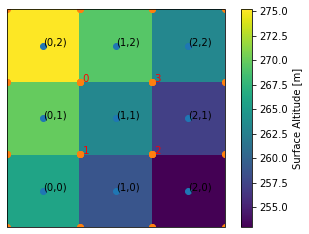

In [119]:
rotated = ccrs.RotatedPole(*pole)
ax = plt.subplot(projection=rotated)

# plot cell centers
subset.orog.plot.pcolormesh(x='rlon', y='rlat', ax=ax)
# plot cell centers
#xr.plot.scatter(subset, x='lon', y='lat', transform=ccrs.PlateCarree())
xr.plot.scatter(subset, x='rlon', y='rlat', transform=rotated)
# plot cell vertices
xr.plot.scatter(subset, x='lon_vertices', y='lat_vertices', transform=ccrs.PlateCarree())

# annotate cell centers with logical grid index
for (i, j), element in np.ndenumerate(subset.lon.values):
    ax.annotate("({},{})".format(i,j), (subset.rlon.isel(rlon=i), subset.rlat.isel(rlat=j))) #xycoords=transform_plate)

transform_plate = ccrs.PlateCarree()._as_mpl_transform(ax)
i = 1; j = 1
for k in range(subset.vertices.size):
    ax.annotate(" {}".format(k), 
                (subset.lon_vertices.isel(rlon=i, rlat=j, vertices=k), 
                 subset.lat_vertices.isel(rlon=i, rlat=j, vertices=k)), 
                xycoords=transform_plate, color="red")

Note that the ordering of vertices starts at the top left (facing cell (`i-1`, `j+1`)). It seems to be different from what's expected in the [CF-conventions](https://cfconventions.org/cf-conventions/cf-conventions.html#cell-boundaries) which states that the 0-index should define the vertex facing cell (`i-1`, `j-1`).  This causes problems in other CF compliant tools like, e.g., `cf_xarray`, see also [cf_xarray.bounds_to_vertices](https://cf-xarray.readthedocs.io/en/latest/generated/cf_xarray.bounds_to_vertices.html). This seems to be the same for a lot of cmorized datasets i looked at.

Just to demonstrate here, i use `cf_xarray` to expand vertices into bounds of dimensions (`rlon`+1, `rlat`+1) and again plot those.

In [112]:
import cf_xarray as cfxr

In [114]:
def roll_vertices(ds):
    """roll vertices into an order beginning at lower left"""
    ds = ds.copy()
    ds['lon_vertices'] = ds.lon_vertices.roll(vertices=-1)
    ds['lat_vertices'] = ds.lat_vertices.roll(vertices=-1)
    return ds

def bounds_to_vertices(ds):
    lon_bounds = cfxr.bounds_to_vertices(ds.lon_vertices, bounds_dim='vertices')
    lat_bounds = cfxr.bounds_to_vertices(ds.lat_vertices, bounds_dim='vertices')
    lon_bounds.name = 'lon_bounds'
    lat_bounds.name = 'lat_bounds'
    return xr.merge([lon_bounds, lat_bounds])

### Plot without rolling:

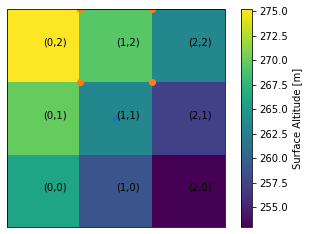

In [120]:
bounds = bounds_to_vertices(subset)

ax = plt.subplot(projection=rotated)

# plot cell centers
subset.orog.plot.pcolormesh(x='rlon', y='rlat', ax=ax)
xr.plot.scatter(subset.isel(rlon=1, rlat=1), x='rlon', y='rlat', transform=rotated)
# the bounds for cell (1,1) should be ((1,2), (1,2))
xr.plot.scatter(bounds.isel(rlon_vertices=slice(1,3), rlat_vertices=slice(1,3)), x='lon_bounds', y='lat_bounds', transform=ccrs.PlateCarree())

# annotate cell centers with logical grid index
for (i, j), element in np.ndenumerate(subset.lon.values):
    ax.annotate("({},{})".format(i,j), (subset.rlon.isel(rlon=i), subset.rlat.isel(rlat=j)))

So this shifts vertices to an incorrect position since `cf_xarray` assumes the 0th vertices at the lower left. If we roll the vertices, we again get the correct positions of the vertices.

### Plot with rolling

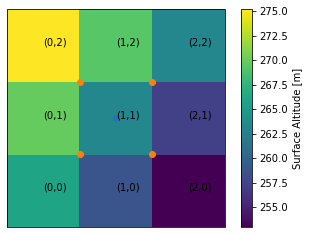

In [121]:
bounds = bounds_to_vertices(roll_vertices(subset))

ax = plt.subplot(projection=rotated)

# plot cell centers
subset.orog.plot.pcolormesh(x='rlon', y='rlat', ax=ax)
xr.plot.scatter(subset.isel(rlon=1, rlat=1), x='rlon', y='rlat', transform=rotated)
# the bounds for cell (1,1) should be ((1,2), (1,2))
xr.plot.scatter(bounds.isel(rlon_vertices=slice(1,3), rlat_vertices=slice(1,3)), x='lon_bounds', y='lat_bounds', transform=ccrs.PlateCarree())

# annotate cell centers with logical grid index
for (i, j), element in np.ndenumerate(subset.lon.values):
    ax.annotate("({},{})".format(i,j), (subset.rlon.isel(rlon=i), subset.rlat.isel(rlat=j)))

The problem is basically when it comes to conservative remapping. E.g., `xesmf` relies on `cf_xarray` to decode vertices correctly while `cf_xarray` relies on the CF-convention. The question is how `cdo` manages the vertices order internally, not only for the `cdo cmor` operator but also for `remapcon` if a curvilinear grid is present. At least, i experienced that `cdo remapcon` is sensitive to the vertices order, e.g., i get different results with and without rolling the vertices before remapping.